In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import slot

plt.rcParams['animation.ffmpeg_path'] = 'C:/FFmpeg/bin/ffmpeg.exe'

In [12]:
class MAB:
    def __init__(self, bpl, slots, bandit_probs):
        
        # bandit의 확률 저장
        self.bandit_probs = bandit_probs
        # bet per line 저장
        self.bpl = bpl
        # slot의 수 저장
        self.N = len(slots)
        # platinum slot 저장
        self.slot_platinum = slot.game_platinum(bpl)
        # monster slot 저장
        self.slot_monster = slot.game_monster(bpl)
        # masquerade slot 저장
        # self.slot_masque = slot.game_masque(bpl)

    def draw(self, k):
        if k == 0:
            return self.slot_platinum.play_platinum(), np.max(self.bandit_probs) - self.bandit_probs[k]
        elif k == 1:
            return self.slot_monster.play_monster(), np.max(self.bandit_probs) - self.bandit_probs[k]


In [13]:
# bandit의 rtp 저장
rtp_values = np.array([0.583, 0.416])

# bet per line 값
bpl = 2000

# slot의 종류
slots = ['Platinum', 'monster']

In [14]:
# MAB class
mab = MAB(bpl, slots, rtp_values)

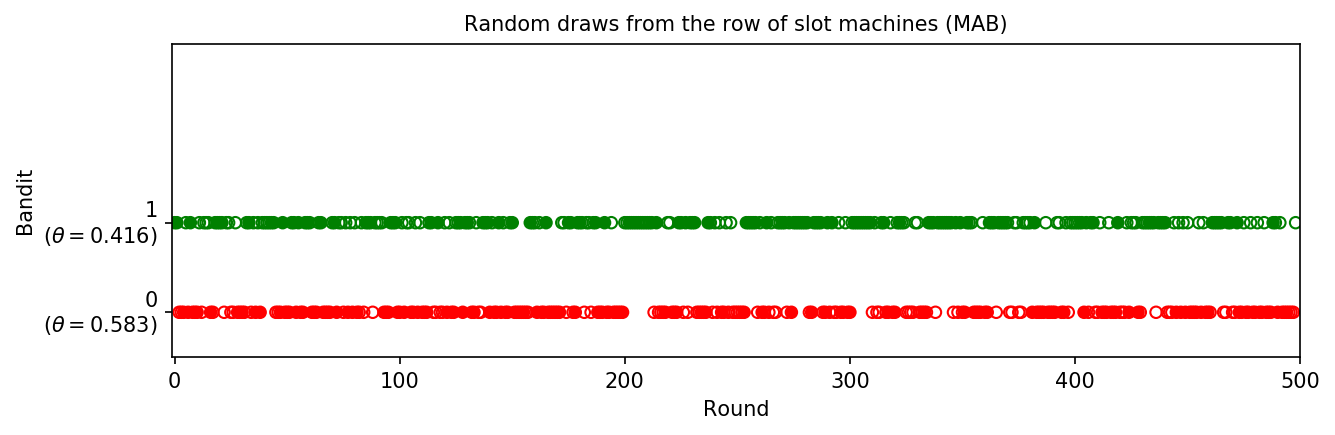

In [15]:
# draw 수
N_DRAWS = 500

# bandit의 수
N_BANDITS = len(slots)

# 누적 draw, bandit의 선택과 보상을 위한
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# visualization을 위한 list
k_list = []
reward_list = []

# fig 설정
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# 각 bandit의 색상
bandit_colors = ['red', 'green']

# draw 반복
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = np.random.choice(range(N_BANDITS),1)[0]
    reward, regret = mab.draw(k)
    
    if reward > 0:
        reward = 1
    else:
        reward = 0
    
    # 이 draw 정보 기록
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    
    # bandit의 color list
    color_list = [bandit_colors[k] for k in k_list]
    
    # reward의 facecolor
    facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]    

# 데이터 initializing
scatter = ax.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

# 시각화 타이틀
plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, rtp_values[i]) for i in range(2)])
ax.tick_params(labelsize=10)
fig.tight_layout()

# update를 위한 함수
def animate(i):
    x = list(range(N_DRAWS))[:i]
    y = k_list[:i]
    scatter.set_offsets(np.c_[x, y])
    scatter.set_color(color_list[:i])
    scatter.set_facecolor(facecolor_list[:i])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, rtp_values[i]) for i in range(2)])
    ax.tick_params(labelsize=10)
    return (scatter,)


# animation 생성 함수
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=25, blit=True)

# 출력
HTML(anim.to_html5_video())